# Interactions or not

Let's say you have two categorical variables. Want to get effect of one on another. 
- interaction or additive
- interaction model has some advantages. you can get the slopes in additive model from interaction model. it's in the contrasts.

Rojan: the interaction model would answer what is the probability of getting admission for each departments for each gender,
whereas non interaction model would answer what is the probability of getting admission for each gender averaged across all the departments

In [233]:
import arviz as az
import daft
from causalgraphicalmodels import CausalGraphicalModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
from scipy.special import expit
from scipy.special import logit
import seaborn as sns
import statsmodels.api as sm

<IPython.core.display.Javascript object>

In [234]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


<IPython.core.display.Javascript object>

In [235]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Data and DAG

In [236]:
DATA_DIR = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking_2/End_of_chapter_problems/data/'
df_ucb = pd.read_csv(DATA_DIR + "UCBadmit.csv", sep=";", header=0)
# Encode categorical variables
df_ucb["dept_code"] = pd.Categorical(df_ucb["dept"]).codes
df_ucb["gender_code"] = pd.Categorical(df_ucb["applicant.gender"]).codes    # female will be 0, male will be 1

# Numbers of unique variables for use later
n_gid = len(df_ucb['gender_code'].unique())
n_dept = len(df_ucb['dept_code'].unique())
df_ucb.head()

,dept,applicant.gender,admit,reject,applications,dept_code,gender_code
1,A,male,512,313,825,0,1
2,A,female,89,19,108,0,0
3,B,male,353,207,560,1,1
4,B,female,17,8,25,1,0
5,C,male,120,205,325,2,1


<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


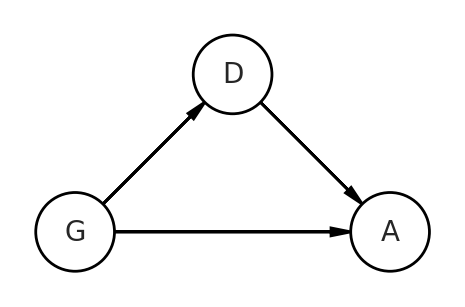

<IPython.core.display.Javascript object>

In [237]:
dag = CausalGraphicalModel(
    nodes=["G", "D", "A"],
    edges=[
        ("G", "D"),
        ("D", "A"),
        ("G", "A"),
    ],
)
pgm = daft.PGM()
coordinates = {
    "D": (1, 1),
    "G": (0, 0),
    "A": (2, 0),
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()

# Conditioning variable as additive term

Rojan:
> what is the probability of getting admission for each gender averaged across all the departments

McEleath
> Instead of asking “What are the average probabilities of admission for women and men across all departments?” we want to ask “What is the average difference in probability of admission between women and men within departments?” In order to ask the second question, we estimate unique female and male admission rates in each department.

We'll be doing this with two models, one fixed effects and one with a varying effects model. The likelihood and logit link functions are the same for both:

$$ A_i \sim \text{Binomial}(N_i, p_i) $$
$$ \text{logit}(p_i) = \alpha_{\text{GID}[i]} + \delta_{\text{DEPT}[i]} $$
$$ \alpha_j \sim \text{Normal}(0, 1.5) \tag{prior for gender} $$
$$ \delta_k \sim \text{Normal}(0, 1.5) \tag{prior for department} $$

In [6]:
df_ucb.head()

,dept,applicant.gender,admit,reject,applications,dept_code,gender_code
1,A,male,512,313,825,0,1
2,A,female,89,19,108,0,0
3,B,male,353,207,560,1,1
4,B,female,17,8,25,1,0
5,C,male,120,205,325,2,1


<IPython.core.display.Javascript object>

In [136]:
# book example, pg 343)
with pm.Model() as mMain:

    # Priors
    a = pm.Normal("a", mu=0, sd=1, shape=n_gid)
    d = pm.Normal("d", mu=0, sd=1, shape=n_dept)

    # linear model with logit link
    p = pm.Deterministic("p", pm.math.invlogit(a[df_ucb["gender_code"]] + d[df_ucb["dept_code"]]))

    # likelihood
    admit = pm.Binomial("admit", n=df_ucb['applications'], p=p, observed=df_ucb['admit'])

    # generate posterior and sample
    trace_Main = pm.sample(draws=5000, tune=1000, return_inferencedata=False, progressbar=False)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d, a]
INFO:pymc3:NUTS: [d, a]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 30 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 30 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [120]:
df_ucb.head()

,dept,applicant.gender,admit,reject,applications,dept_code,gender_code
1,A,male,512,313,825,0,1
2,A,female,89,19,108,0,0
3,B,male,353,207,560,1,1
4,B,female,17,8,25,1,0
5,C,male,120,205,325,2,1


<IPython.core.display.Javascript object>

In [145]:
df_summary_Main = az.summary(trace_Main, var_names=["a", "d"])
df_summary_Main

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.434,0.375,-1.039,0.159,0.008,0.006,2083.0,2083.0,2079.0,2699.0,1.0
a[1],-0.527,0.374,-1.110,0.082,0.008,0.006,2054.0,2054.0,2049.0,2546.0,1.0
d[0],1.106,0.378,0.507,1.715,0.008,0.006,2103.0,2103.0,2097.0,2698.0,1.0
d[1],1.059,0.380,0.445,1.656,0.008,0.006,2126.0,2126.0,2121.0,3048.0,1.0
d[2],-0.150,0.377,-0.766,0.441,0.008,0.006,2106.0,2106.0,2101.0,2787.0,1.0
d[3],-0.183,0.378,-0.809,0.401,0.008,0.006,2115.0,2115.0,2110.0,2787.0,1.0
d[4],-0.623,0.382,-1.229,-0.008,0.008,0.006,2159.0,2159.0,2155.0,2962.0,1.0
d[5],-2.155,0.394,-2.781,-1.525,0.008,0.006,2244.0,2244.0,2236.0,3113.0,1.0


<IPython.core.display.Javascript object>

In [149]:
trace_Main_df = pm.trace_to_dataframe(trace_Main)
trace_Main_df.head()

,a__0,a__1,d__0,d__1,d__2,d__3,d__4,d__5,p__0,p__1,p__2,p__3,p__4,p__5,p__6,p__7,p__8,p__9,p__10,p__11
0,-0.550822,-0.770695,1.277250,1.303665,0.025600,-0.042733,-0.099879,-1.982298,0.623999,0.674021,0.630176,0.679798,0.321891,0.371632,0.307160,0.355820,0.295135,0.342832,0.059918,0.073569
1,-0.565848,-0.640832,1.217053,1.093241,0.075298,0.025308,-0.668516,-2.109529,0.640197,0.657282,0.611212,0.628875,0.362268,0.379764,0.350800,0.368062,0.212596,0.225419,0.060066,0.064442
2,-0.658590,-0.639156,1.229350,1.253438,-0.091486,0.014894,-0.440703,-2.084594,0.643410,0.638939,0.648917,0.644477,0.325054,0.320805,0.348813,0.344412,0.253533,0.249872,0.061586,0.060473
3,-0.248733,-0.344125,0.982375,0.790584,-0.311153,-0.489168,-0.792889,-2.388668,0.654358,0.675604,0.609797,0.632243,0.341801,0.363574,0.302949,0.323463,0.242869,0.260837,0.061066,0.066770
4,-0.134869,-0.278729,0.839810,0.749463,-0.530520,-0.387209,-0.934308,-2.439295,0.636703,0.669282,0.615557,0.648988,0.308050,0.339530,0.339407,0.372367,0.229164,0.255560,0.061918,0.070820


<IPython.core.display.Javascript object>

# Conditioning variable as interactive term

$$ A_i \sim \text{Binomial}(N_i, p_i) $$
$$ \text{logit}(p_i) = \alpha[G_i, D_i] $$
$$ \alpha_j \sim \text{Normal}(0, 1.5) \tag{prior for each gender, department combination} $$

<br>
<br>

$$ A_i \sim \text{Binomial}(N_i, p_i) $$
$$ \text{logit}(p_i) = \alpha_{\text{GID}[i]} + \delta_{\text{DEPT}[i]} $$
$$ \alpha_j \sim \text{Normal}(0, 1.5) \tag{prior for gender} $$
$$ \delta_k \sim \text{Normal}(0, 1.5) \tag{prior for department} $$

Rojan says interaction is like pandas groupby

In [110]:
df_ucb.head()

,dept,applicant.gender,admit,reject,applications,dept_code,gender_code
1,A,male,512,313,825,0,1
2,A,female,89,19,108,0,0
3,B,male,353,207,560,1,1
4,B,female,17,8,25,1,0
5,C,male,120,205,325,2,1


<IPython.core.display.Javascript object>

In [118]:
df_ucb[df_ucb['applicant.gender']=='male']

,dept,applicant.gender,admit,reject,applications,dept_code,gender_code
1,A,male,512,313,825,0,1
3,B,male,353,207,560,1,1
5,C,male,120,205,325,2,1
7,D,male,138,279,417,3,1
9,E,male,53,138,191,4,1
11,F,male,22,351,373,5,1


<IPython.core.display.Javascript object>

In [117]:
df_ucb.groupby(['gender_code', 'dept_code']).sum()

admit  reject  applications
gender_code dept_code                             
0           0             89      19           108
            1             17       8            25
            2            202     391           593
            3            131     244           375
            4             94     299           393
            5             24     317           341
1           0            512     313           825
            1            353     207           560
            2            120     205           325
            3            138     279           417
            4             53     138           191
            5             22     351           373

<IPython.core.display.Javascript object>

They're additive on the log-odds scale, then take inverse logit.

In [37]:
df_ucb['admit'] / df_ucb['applications']

1     0.620606
2     0.824074
3     0.630357
4     0.680000
5     0.369231
6     0.340641
7     0.330935
8     0.349333
9     0.277487
10    0.239186
11    0.058981
12    0.070381
dtype: float64

<IPython.core.display.Javascript object>

#### Matrix way (like 2022 lecture 9)

In [139]:
# model without weighting

gi = df_ucb["gender_code"]
di = df_ucb["dept_code"]

with pm.Model() as mInteractive:

    # Priors
    a = pm.Normal("a", mu=0, sd=1, shape=(2, n_dept))

    # linear model with logit link
    p = pm.Deterministic("p", pm.math.invlogit(a[gi, di]))

    # likelihood
    admit = pm.Binomial("admit", n=df_ucb['applications'], p=p, observed=df_ucb['admit'])

    # generate posterior and sample
    trace_Interactive = pm.sample(draws=5000, tune=1000, return_inferencedata=False, progressbar=False, target_accept=0.95)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 21 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 21 seconds.


<IPython.core.display.Javascript object>

In [144]:
df_summary_Interactive = az.summary(trace_Interactive, var_names=['a'])
df_summary_Interactive

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"a[0,0]",1.470,0.241,1.094,1.864,0.001,0.001,27744.0,25603.0,28104.0,15127.0,1.0
"a[0,1]",0.661,0.395,0.037,1.295,0.002,0.002,26820.0,18979.0,27028.0,14991.0,1.0
"a[0,2]",-0.657,0.086,-0.798,-0.521,0.001,0.000,25374.0,24798.0,25384.0,15725.0,1.0
"a[0,3]",-0.615,0.107,-0.779,-0.437,0.001,0.000,24434.0,23979.0,24439.0,16051.0,1.0
"a[0,4]",-1.144,0.116,-1.329,-0.956,0.001,0.001,23996.0,23517.0,24119.0,15177.0,1.0
"a[0,5]",-2.491,0.199,-2.802,-2.171,0.001,0.001,30888.0,29779.0,31429.0,15031.0,1.0
"a[1,0]",0.491,0.071,0.376,0.602,0.000,0.000,33760.0,32935.0,33758.0,16203.0,1.0
"a[1,1]",0.531,0.087,0.390,0.668,0.001,0.000,30262.0,28833.0,30313.0,15962.0,1.0
"a[1,2]",-0.530,0.113,-0.714,-0.351,0.001,0.000,28610.0,27021.0,28615.0,14819.0,1.0
"a[1,3]",-0.699,0.103,-0.857,-0.529,0.001,0.000,26496.0,25675.0,26518.0,15621.0,1.0


<IPython.core.display.Javascript object>

In [148]:
trace_Interactive_df = pm.trace_to_dataframe(trace_Interactive)
trace_Interactive_df.head()

,a__0_0,a__0_1,a__0_2,a__0_3,a__0_4,a__0_5,a__1_0,a__1_1,a__1_2,a__1_3,...,p__2,p__3,p__4,p__5,p__6,p__7,p__8,p__9,p__10,p__11
0,1.592587,0.192895,-0.805334,-0.531358,-1.071741,-2.808554,0.575912,0.573368,-0.399843,-0.804825,...,0.639540,0.548075,0.401350,0.308886,0.308994,0.370200,0.291264,0.255072,0.059182,0.056864
1,1.321963,1.050580,-0.577621,-0.585604,-1.181611,-2.340850,0.406978,0.488282,-0.636233,-0.665576,...,0.619702,0.740886,0.346099,0.359480,0.339488,0.357644,0.261859,0.234763,0.070137,0.087796
2,1.211633,1.050890,-0.632614,-0.591157,-1.244338,-2.275896,0.414713,0.473083,-0.634657,-0.635736,...,0.616113,0.740946,0.346455,0.346918,0.346211,0.356369,0.284314,0.223682,0.059068,0.093139
3,1.687816,0.763152,-0.598904,-0.772502,-1.164998,-2.511039,0.579594,0.524241,-0.480467,-0.680904,...,0.628139,0.682038,0.382142,0.354594,0.336060,0.315938,0.256701,0.237760,0.067372,0.075088
4,1.671441,1.012294,-0.689247,-0.420439,-1.136077,-2.429459,0.405480,0.502802,-0.512100,-0.788551,...,0.623118,0.733469,0.374701,0.334201,0.312480,0.396412,0.343688,0.243041,0.071226,0.080954


<IPython.core.display.Javascript object>

# Getting average back from the interaction model

Thinking about what the main effects model is telling us. The gender coefficient is the average log-odds of an admit, given the gender.

The interaction is every combination gender and department.

In [146]:
df_summary_Main

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.434,0.375,-1.039,0.159,0.008,0.006,2083.0,2083.0,2079.0,2699.0,1.0
a[1],-0.527,0.374,-1.110,0.082,0.008,0.006,2054.0,2054.0,2049.0,2546.0,1.0
d[0],1.106,0.378,0.507,1.715,0.008,0.006,2103.0,2103.0,2097.0,2698.0,1.0
d[1],1.059,0.380,0.445,1.656,0.008,0.006,2126.0,2126.0,2121.0,3048.0,1.0
d[2],-0.150,0.377,-0.766,0.441,0.008,0.006,2106.0,2106.0,2101.0,2787.0,1.0
d[3],-0.183,0.378,-0.809,0.401,0.008,0.006,2115.0,2115.0,2110.0,2787.0,1.0
d[4],-0.623,0.382,-1.229,-0.008,0.008,0.006,2159.0,2159.0,2155.0,2962.0,1.0
d[5],-2.155,0.394,-2.781,-1.525,0.008,0.006,2244.0,2244.0,2236.0,3113.0,1.0


<IPython.core.display.Javascript object>

In [147]:
df_summary_Interactive

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"a[0,0]",1.470,0.241,1.094,1.864,0.001,0.001,27744.0,25603.0,28104.0,15127.0,1.0
"a[0,1]",0.661,0.395,0.037,1.295,0.002,0.002,26820.0,18979.0,27028.0,14991.0,1.0
"a[0,2]",-0.657,0.086,-0.798,-0.521,0.001,0.000,25374.0,24798.0,25384.0,15725.0,1.0
"a[0,3]",-0.615,0.107,-0.779,-0.437,0.001,0.000,24434.0,23979.0,24439.0,16051.0,1.0
"a[0,4]",-1.144,0.116,-1.329,-0.956,0.001,0.001,23996.0,23517.0,24119.0,15177.0,1.0
"a[0,5]",-2.491,0.199,-2.802,-2.171,0.001,0.001,30888.0,29779.0,31429.0,15031.0,1.0
"a[1,0]",0.491,0.071,0.376,0.602,0.000,0.000,33760.0,32935.0,33758.0,16203.0,1.0
"a[1,1]",0.531,0.087,0.390,0.668,0.001,0.000,30262.0,28833.0,30313.0,15962.0,1.0
"a[1,2]",-0.530,0.113,-0.714,-0.351,0.001,0.000,28610.0,27021.0,28615.0,14819.0,1.0
"a[1,3]",-0.699,0.103,-0.857,-0.529,0.001,0.000,26496.0,25675.0,26518.0,15621.0,1.0


<IPython.core.display.Javascript object>

In [150]:
trace_Interactive_df.head()

,a__0_0,a__0_1,a__0_2,a__0_3,a__0_4,a__0_5,a__1_0,a__1_1,a__1_2,a__1_3,...,p__2,p__3,p__4,p__5,p__6,p__7,p__8,p__9,p__10,p__11
0,1.592587,0.192895,-0.805334,-0.531358,-1.071741,-2.808554,0.575912,0.573368,-0.399843,-0.804825,...,0.639540,0.548075,0.401350,0.308886,0.308994,0.370200,0.291264,0.255072,0.059182,0.056864
1,1.321963,1.050580,-0.577621,-0.585604,-1.181611,-2.340850,0.406978,0.488282,-0.636233,-0.665576,...,0.619702,0.740886,0.346099,0.359480,0.339488,0.357644,0.261859,0.234763,0.070137,0.087796
2,1.211633,1.050890,-0.632614,-0.591157,-1.244338,-2.275896,0.414713,0.473083,-0.634657,-0.635736,...,0.616113,0.740946,0.346455,0.346918,0.346211,0.356369,0.284314,0.223682,0.059068,0.093139
3,1.687816,0.763152,-0.598904,-0.772502,-1.164998,-2.511039,0.579594,0.524241,-0.480467,-0.680904,...,0.628139,0.682038,0.382142,0.354594,0.336060,0.315938,0.256701,0.237760,0.067372,0.075088
4,1.671441,1.012294,-0.689247,-0.420439,-1.136077,-2.429459,0.405480,0.502802,-0.512100,-0.788551,...,0.623118,0.733469,0.374701,0.334201,0.312480,0.396412,0.343688,0.243041,0.071226,0.080954


<IPython.core.display.Javascript object>

In [151]:
f_cols = [col for col in trace_Interactive_df.columns if 'a__0' in col]
m_cols = [col for col in trace_Interactive_df.columns if 'a__1' in col]

<IPython.core.display.Javascript object>

In [160]:
# log-odds scale
az.summary(np.array(trace_Interactive_df[f_cols]))

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (20000) than draws (6). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,-0.463,1.286,-2.592,1.559,0.002,0.001,609502.0,609502.0,609502.0,609502.0,1.2


<IPython.core.display.Javascript object>

In [161]:
az.summary(np.array(trace_Interactive_df[m_cols]))

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (20000) than draws (6). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,-0.635,1.077,-2.624,0.655,0.001,0.001,609502.0,609502.0,609502.0,609502.0,1.38


<IPython.core.display.Javascript object>

In [157]:
# probability scale
az.summary(np.array(expit(trace_Interactive_df[f_cols].sum(axis=1))))

arviz - WARNING - Shape validation failed: input_shape: (1, 20000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,0.066,0.034,0.018,0.11,0.0,0.0,22200.0,17886.0,26135.0,15742.0,NaN


<IPython.core.display.Javascript object>

In [158]:
az.summary(np.array(expit(trace_Interactive_df[m_cols].sum(axis=1))))

arviz - WARNING - Shape validation failed: input_shape: (1, 20000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,0.023,0.007,0.012,0.033,0.0,0.0,27570.0,23082.0,29588.0,15360.0,NaN


<IPython.core.display.Javascript object>

In [166]:
d_cols = [col for col in trace_Main_df.columns if 'd__' in col]
az.summary(np.array(trace_Main_df['a__0'] + trace_Main_df[d_cols].sum(axis=1)))

arviz - WARNING - Shape validation failed: input_shape: (1, 20000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,-1.379,1.857,-4.349,1.55,0.041,0.029,2016.0,2016.0,2011.0,2493.0,NaN


<IPython.core.display.Javascript object>

### TRY POST-STRATIFICATION

### Why doesn't linear model (book way) get the same answer?

Compare logit transformation below with matrix (lecture) way.

In [439]:
logit(az.summary(idata_mq2_book, var_names='p')['mean'])

p[0]     0.575364
p[1]     0.672220
p[2]     0.532217
p[3]     0.623438
p[4]    -0.676692
p[5]    -0.584055
p[6]    -0.708185
p[7]    -0.614646
p[8]    -1.147205
p[9]    -1.051173
p[10]   -2.666159
p[11]   -2.586689
Name: mean, dtype: float64

<IPython.core.display.Javascript object>

In [444]:
az.summary(idata_mq2_lec, var_names='a')['mean']

a[0,0]    1.471
a[0,1]    0.662
a[0,2]   -0.657
a[0,3]   -0.615
a[0,4]   -1.146
a[0,5]   -2.491
a[1,0]    0.490
a[1,1]    0.531
a[1,2]   -0.530
a[1,3]   -0.699
a[1,4]   -0.938
a[1,5]   -2.664
Name: mean, dtype: float64

<IPython.core.display.Javascript object>

In [445]:
expit(az.summary(idata_mq2_lec, var_names='p')['mean'])

p[0]     0.650219
p[1]     0.692110
p[2]     0.652263
p[3]     0.657911
p[4]     0.591701
p[5]     0.584676
p[6]     0.582246
p[7]     0.586860
p[8]     0.570036
p[9]     0.560206
p[10]    0.516494
p[11]    0.519490
Name: mean, dtype: float64

<IPython.core.display.Javascript object>

In [ ]:
# check contrasts

In [452]:
# idata_mq2_book_df = idata_mq2_book.to_dataframe()

# post_diff_ucb_book = dict()
# for i in df_ucb.index:
#     if i % 2 == 0:
#         post_diff_ucb_book[df_ucb.loc[i, 'dept']] = idata_mq2_book_df[('posterior', f'p[{i+1}]', i+1)] - idata_mq2_book_df[('posterior', f'p[{i}]', i)]

<IPython.core.display.Javascript object>

In [19]:
idata_mq2_lec_df = pm.trace_to_dataframe(idata_mq2_lec)
idata_mq2_lec_df.head()

,a__0_0,a__0_1,a__0_2,a__0_3,a__0_4,a__0_5,a__1_0,a__1_1,a__1_2,a__1_3,...,p__2,p__3,p__4,p__5,p__6,p__7,p__8,p__9,p__10,p__11
0,0.891069,1.641279,-0.521474,-0.646311,-1.052864,-2.699225,0.611370,0.651254,-0.518243,-0.645239,...,0.657293,0.837709,0.373263,0.372508,0.344063,0.343821,0.271126,0.258675,0.086586,0.063019
1,1.927675,0.575378,-0.783576,-0.550105,-1.222880,-2.794901,0.353855,0.390752,-0.536723,-0.595988,...,0.596464,0.640003,0.368950,0.313550,0.355262,0.365840,0.299623,0.227430,0.060891,0.057600
2,1.938643,0.607025,-0.663745,-0.778497,-0.931355,-2.535624,0.520048,0.503298,-0.486455,-0.777678,...,0.623234,0.647262,0.380729,0.339899,0.314820,0.314644,0.284581,0.282650,0.055522,0.073398
3,1.730108,0.910071,-0.661863,-0.693358,-1.125136,-2.493848,0.501386,0.625492,-0.310426,-0.702095,...,0.651466,0.713015,0.423011,0.340321,0.331348,0.333287,0.277520,0.245060,0.049939,0.076291
4,1.614487,0.835652,-0.661002,-0.756671,-0.963028,-2.688075,0.561555,0.535844,-0.621586,-0.777209,...,0.630845,0.697549,0.349421,0.340514,0.314922,0.319370,0.225927,0.276272,0.047908,0.063681


<IPython.core.display.Javascript object>

In [20]:
az.summary(idata_m1f, var_names=["a"])

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.428,0.367,-1.013,0.153,0.008,0.006,2195.0,2084.0,2197.0,2583.0,1.0
a[1],-0.521,0.366,-1.098,0.062,0.008,0.006,2201.0,2179.0,2203.0,2568.0,1.0


<IPython.core.display.Javascript object>

My goal is to get the same values from the additive model back from the interaction model. I'm not sure if this is right way yet.

In [132]:
f_cols = [col for col in idata_mq2_lec_df.columns if 'a__0' in col]
# need to sum across columns to collapse the departments
az.summary(np.array(idata_mq2_lec_df[f_cols].sum(axis=1)))

arviz - WARNING - Shape validation failed: input_shape: (1, 20000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,-2.783,0.548,-3.687,-1.946,0.003,0.002,30535.0,29517.0,30566.0,15458.0,NaN


<IPython.core.display.Javascript object>

In [133]:
m_cols = [col for col in idata_mq2_lec_df.columns if 'a__1' in col]
az.summary(np.array(idata_mq2_lec_df[m_cols].sum(axis=1)))

arviz - WARNING - Shape validation failed: input_shape: (1, 20000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,-3.812,0.323,-4.342,-3.313,0.002,0.001,29589.0,29198.0,29595.0,15649.0,NaN


<IPython.core.display.Javascript object>

In [135]:
# az.summary(np.array(idata_mq2_lec_df[f_cols].sum(axis=1)) - np.array(idata_mq2_lec_df[m_cols].sum(axis=1)))

<IPython.core.display.Javascript object>

That doesn't look right. I'll try the post-stratification approach.

In [26]:
df_ucb.head()

,dept,applicant.gender,admit,reject,applications,dept_code,gender_code
1,A,male,512,313,825,0,1
2,A,female,89,19,108,0,0
3,B,male,353,207,560,1,1
4,B,female,17,8,25,1,0
5,C,male,120,205,325,2,1


<IPython.core.display.Javascript object>

In [209]:
# number of applications to simulate
total_apps = df_ucb['applications'].sum()

# number of applications per discipline
apps_per_disc = df_ucb.groupby('dept').sum()['applications'].reset_index()

app_list = list()
for i in apps_per_disc.index:
    app_list += ([i] * apps_per_disc.loc[i, 'applications'])

<IPython.core.display.Javascript object>

In [210]:
df_g0 = pd.DataFrame(
    {
        "D": app_list,
        "N": [1] * total_apps,
        "G": [0] * total_apps,
    }
)

df_g1 = pd.DataFrame(
    {
        "D": app_list,
        "N": [1] * total_apps,
        "G": [1] * total_apps,
    }
)

<IPython.core.display.Javascript object>

In [211]:
# Initialize for speed
p_G0 = np.zeros((len(df_g0), len(idata_mq2_lec_df)))
p_G1 = np.zeros((len(df_g1), len(idata_mq2_lec_df)))

<IPython.core.display.Javascript object>

In [212]:
df_ucb

,dept,applicant.gender,admit,reject,applications,dept_code,gender_code
1,A,male,512,313,825,0,1
2,A,female,89,19,108,0,0
3,B,male,353,207,560,1,1
4,B,female,17,8,25,1,0
5,C,male,120,205,325,2,1
6,C,female,202,391,593,2,0
7,D,male,138,279,417,3,1
8,D,female,131,244,375,3,0
9,E,male,53,138,191,4,1
10,E,female,94,299,393,4,0


<IPython.core.display.Javascript object>

In [214]:
trace_Interactive_df.head()

,a__0_0,a__0_1,a__0_2,a__0_3,a__0_4,a__0_5,a__1_0,a__1_1,a__1_2,a__1_3,...,p__2,p__3,p__4,p__5,p__6,p__7,p__8,p__9,p__10,p__11
0,1.592587,0.192895,-0.805334,-0.531358,-1.071741,-2.808554,0.575912,0.573368,-0.399843,-0.804825,...,0.639540,0.548075,0.401350,0.308886,0.308994,0.370200,0.291264,0.255072,0.059182,0.056864
1,1.321963,1.050580,-0.577621,-0.585604,-1.181611,-2.340850,0.406978,0.488282,-0.636233,-0.665576,...,0.619702,0.740886,0.346099,0.359480,0.339488,0.357644,0.261859,0.234763,0.070137,0.087796
2,1.211633,1.050890,-0.632614,-0.591157,-1.244338,-2.275896,0.414713,0.473083,-0.634657,-0.635736,...,0.616113,0.740946,0.346455,0.346918,0.346211,0.356369,0.284314,0.223682,0.059068,0.093139
3,1.687816,0.763152,-0.598904,-0.772502,-1.164998,-2.511039,0.579594,0.524241,-0.480467,-0.680904,...,0.628139,0.682038,0.382142,0.354594,0.336060,0.315938,0.256701,0.237760,0.067372,0.075088
4,1.671441,1.012294,-0.689247,-0.420439,-1.136077,-2.429459,0.405480,0.502802,-0.512100,-0.788551,...,0.623118,0.733469,0.374701,0.334201,0.312480,0.396412,0.343688,0.243041,0.071226,0.080954


<IPython.core.display.Javascript object>

In [215]:
# Dataframe is the same between genders, so use just one to get discipline and apply it to both
for i in range(len(df_g0)):
    disc = df_g0.loc[i, 'D']
    p_G0[i, :] = trace_Interactive_df[f'a__0_{disc}']
    p_G1[i, :] = trace_Interactive_df[f'a__1_{disc}']

<IPython.core.display.Javascript object>

In [218]:
df_g0.head()

,D,N,G
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


<IPython.core.display.Javascript object>

In [217]:
p_G0.shape

(4526, 20000)

<IPython.core.display.Javascript object>

In [228]:
az.summary((p_G0.sum(axis=0) / 20000))

arviz - WARNING - Shape validation failed: input_shape: (1, 20000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,-0.089,0.019,-0.12,-0.06,0.0,0.0,26252.0,25758.0,26284.0,16056.0,NaN


<IPython.core.display.Javascript object>

In [229]:
az.summary((p_G1.sum(axis=0) / 20000))

arviz - WARNING - Shape validation failed: input_shape: (1, 20000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,-0.136,0.012,-0.155,-0.118,0.0,0.0,29457.0,29135.0,29466.0,15821.0,NaN


<IPython.core.display.Javascript object>

In [232]:
az.summary((p_G0.sum(axis=1) / p_G0.shape[0]))

arviz - WARNING - Shape validation failed: input_shape: (1, 4526), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,-1.736,5.675,-11.006,6.495,4.715,4.42,1.0,1.0,2.0,4.0,NaN


<IPython.core.display.Javascript object>

In [230]:
az.summary((p_G1.sum(axis=1) / p_G1.shape[0]))

arviz - WARNING - Shape validation failed: input_shape: (1, 4526), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,-2.658,4.638,-11.782,2.348,3.822,3.557,1.0,1.0,1.0,4.0,NaN


<IPython.core.display.Javascript object>

In [221]:
az.summary(np.array(p_G0))

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

# Conditioning variable as additive term as an indicator

The dataframe will have gender as an indicator variable.

| id | G0  | G1  | D  |
| -- | -- |  --  | -- | 
| 0 | 0 | 1  | 5
| 1 | 1 | 0  | 2
| 2 | 1 | 0  | 3
| 3 | 0 | 1  | 1

$$ A_i \sim \text{Binomial}(1, p_i) $$
$$ \text{logit}(p_i) = \beta_0[i] + \beta_1[i] + \delta_{\text{DEPT}[i]} $$
$$ \beta_0 \sim \text{Normal}(0, 1.5) \tag{prior for female} $$
$$ \beta_1 \sim \text{Normal}(0, 1.5) \tag{prior for male} $$
$$ \delta_k \sim \text{Normal}(0, 1.5) \tag{prior for department} $$

Restructure the dataframe.

In [84]:
df_ucb

,dept,applicant.gender,admit,reject,applications,dept_code,gender_code
1,A,male,512,313,825,0,1
2,A,female,89,19,108,0,0
3,B,male,353,207,560,1,1
4,B,female,17,8,25,1,0
5,C,male,120,205,325,2,1
6,C,female,202,391,593,2,0
7,D,male,138,279,417,3,1
8,D,female,131,244,375,3,0
9,E,male,53,138,191,4,1
10,E,female,94,299,393,4,0


<IPython.core.display.Javascript object>

In [87]:
f_list = list()
m_list = list()
d_list = list()
admit_list = list()
for i, row in df_ucb.iterrows():
    if row['applicant.gender'] == 'male':
        f_list += row['applications'] * [0]
        m_list += row['applications'] * [1]
    else:
        f_list += row['applications'] * [1]
        m_list += row['applications'] * [0]
    d_list += row['applications'] * [row['dept_code']]
    admit_list += row['admit'] * [1] + row['reject'] * [0]

df_ucb_restructure = pd.DataFrame()
df_ucb_restructure['F'] = f_list
df_ucb_restructure['M'] = m_list
df_ucb_restructure['D'] = d_list
df_ucb_restructure['A'] = admit_list
df_ucb_restructure['N'] = 1

df_ucb_restructure.head()

,F,M,D,A,N
0,0,1,0,1,1
1,0,1,0,1,1
2,0,1,0,1,1
3,0,1,0,1,1
4,0,1,0,1,1


<IPython.core.display.Javascript object>

In [86]:
# verify data is correct
# df_ucb_restructure.groupby(['D', 'F', 'M']).sum()

<IPython.core.display.Javascript object>

In [91]:
with pm.Model() as mIndicator:

    # Priors
    b0 = pm.Normal("b0", mu=0, sd=1)
    b1 = pm.Normal("b1", mu=0, sd=1)
    d = pm.Normal("d", mu=0, sd=1, shape=n_dept)

    # linear model with logit link
    p = pm.Deterministic("p", pm.math.invlogit(b0 * df_ucb_restructure['F'] + b1 * df_ucb_restructure['M'] + d[df_ucb_restructure['D']]))

    # likelihood
    admit = pm.Binomial("admit", n=1, p=p, observed=df_ucb_restructure['A'])

    # generate posterior and sample
    idata_mIndicator = pm.sample(draws=5000, tune=1000, return_inferencedata=False, progressbar=False, target_accept=0.95)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d, b1, b0]
INFO:pymc3:NUTS: [d, b1, b0]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 104 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 104 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [93]:
az.summary(idata_mIndicator, var_names=['b0', 'b1', 'd'])

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b0,-0.434,0.369,-1.001,0.173,0.008,0.006,2082.0,1820.0,2100.0,1982.0,1.0
b1,-0.528,0.368,-1.101,0.064,0.008,0.006,2078.0,1844.0,2096.0,2031.0,1.0
d[0],1.107,0.372,0.498,1.679,0.008,0.006,2135.0,2008.0,2153.0,2150.0,1.0
d[1],1.061,0.374,0.468,1.654,0.008,0.006,2145.0,2016.0,2162.0,2246.0,1.0
d[2],-0.150,0.371,-0.729,0.449,0.008,0.006,2118.0,1918.0,2135.0,2013.0,1.0
d[3],-0.182,0.373,-0.768,0.415,0.008,0.006,2088.0,1908.0,2108.0,2014.0,1.0
d[4],-0.623,0.376,-1.237,-0.041,0.008,0.006,2174.0,2174.0,2191.0,2057.0,1.0
d[5],-2.154,0.389,-2.813,-1.580,0.008,0.006,2303.0,2303.0,2317.0,2340.0,1.0


<IPython.core.display.Javascript object>

In [ ]:
f_cols = [col for col in idata_mq2_lec_df.columns if 'a__0' in col]
az.summary(np.array(idata_mq2_lec_df[f_cols]))

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (20000) than draws (6). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,-0.464,1.287,-2.622,1.533,0.002,0.001,609502.0,609502.0,609502.0,609502.0,1.2


<IPython.core.display.Javascript object>

In [ ]:
m_cols = [col for col in idata_mq2_lec_df.columns if 'a__1' in col]
az.summary(np.array(idata_mq2_lec_df[m_cols]))

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (20000) than draws (6). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,-0.635,1.076,-2.618,0.661,0.001,0.001,609502.0,609502.0,609502.0,609502.0,1.38


<IPython.core.display.Javascript object>

In [94]:
az.summary(idata_mq2_lec, var_names='a')

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"a[0,0]",1.471,0.243,1.066,1.846,0.001,0.001,30828.0,28961.0,31112.0,15477.0,1.0
"a[0,1]",0.658,0.400,0.006,1.283,0.002,0.002,31188.0,20008.0,31527.0,15771.0,1.0
"a[0,2]",-0.656,0.087,-0.796,-0.519,0.000,0.000,34659.0,33532.0,34751.0,15224.0,1.0
"a[0,3]",-0.617,0.109,-0.790,-0.443,0.001,0.000,32598.0,30714.0,32694.0,15600.0,1.0
"a[0,4]",-1.145,0.118,-1.333,-0.960,0.001,0.000,34526.0,33690.0,34528.0,15237.0,1.0
"a[0,5]",-2.493,0.201,-2.810,-2.175,0.001,0.001,29027.0,27999.0,29480.0,14351.0,1.0
"a[1,0]",0.490,0.072,0.377,0.607,0.000,0.000,31640.0,30573.0,31648.0,15553.0,1.0
"a[1,1]",0.531,0.087,0.392,0.669,0.000,0.000,32126.0,30496.0,32189.0,15287.0,1.0
"a[1,2]",-0.530,0.114,-0.710,-0.347,0.001,0.000,31702.0,28703.0,31756.0,15967.0,1.0
"a[1,3]",-0.699,0.103,-0.869,-0.540,0.001,0.000,31358.0,29967.0,31440.0,15144.0,1.0


<IPython.core.display.Javascript object>

In [102]:
idata_mq2_lec_df.head()

,a__0_0,a__0_1,a__0_2,a__0_3,a__0_4,a__0_5,a__1_0,a__1_1,a__1_2,a__1_3,...,p__2,p__3,p__4,p__5,p__6,p__7,p__8,p__9,p__10,p__11
0,0.891069,1.641279,-0.521474,-0.646311,-1.052864,-2.699225,0.611370,0.651254,-0.518243,-0.645239,...,0.657293,0.837709,0.373263,0.372508,0.344063,0.343821,0.271126,0.258675,0.086586,0.063019
1,1.927675,0.575378,-0.783576,-0.550105,-1.222880,-2.794901,0.353855,0.390752,-0.536723,-0.595988,...,0.596464,0.640003,0.368950,0.313550,0.355262,0.365840,0.299623,0.227430,0.060891,0.057600
2,1.938643,0.607025,-0.663745,-0.778497,-0.931355,-2.535624,0.520048,0.503298,-0.486455,-0.777678,...,0.623234,0.647262,0.380729,0.339899,0.314820,0.314644,0.284581,0.282650,0.055522,0.073398
3,1.730108,0.910071,-0.661863,-0.693358,-1.125136,-2.493848,0.501386,0.625492,-0.310426,-0.702095,...,0.651466,0.713015,0.423011,0.340321,0.331348,0.333287,0.277520,0.245060,0.049939,0.076291
4,1.614487,0.835652,-0.661002,-0.756671,-0.963028,-2.688075,0.561555,0.535844,-0.621586,-0.777209,...,0.630845,0.697549,0.349421,0.340514,0.314922,0.319370,0.225927,0.276272,0.047908,0.063681


<IPython.core.display.Javascript object>

In [109]:
az.summary(np.array(expit(idata_mq2_lec_df[m_cols].sum(axis=1) - idata_mq2_lec_df[f_cols].sum(axis=1))))

arviz - WARNING - Shape validation failed: input_shape: (1, 20000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,0.28,0.119,0.091,0.456,0.001,0.001,29348.0,22996.0,31385.0,14737.0,NaN


<IPython.core.display.Javascript object>

Always do the transformation last...

# Even simpler comparison

$$ A_i \sim \text{Binomial}(1, p_i) $$
$$ \text{logit}(p_i) = \beta_0[i] + \beta_1[i] $$
$$ \beta_0 \sim \text{Normal}(0, 1.5) \tag{prior for female} $$
$$ \beta_1 \sim \text{Normal}(0, 1.5) \tag{prior for male} $$

In [95]:
with pm.Model() as mIndicator:

    # Priors
    b0 = pm.Normal("b0", mu=0, sd=1)
    b1 = pm.Normal("b1", mu=0, sd=1)

    # linear model with logit link
    p = pm.Deterministic("p", pm.math.invlogit(b0 * df_ucb_restructure['F'] + b1 * df_ucb_restructure['M']))

    # likelihood
    admit = pm.Binomial("admit", n=1, p=p, observed=df_ucb_restructure['A'])

    # generate posterior and sample
    idata_mIndicator = pm.sample(draws=5000, tune=1000, return_inferencedata=False, progressbar=False, target_accept=0.95)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b1, b0]
INFO:pymc3:NUTS: [b1, b0]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 32 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 32 seconds.


<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b0,-0.828,0.052,-0.914,-0.748,0.0,0.0,12547.0,12432.0,12539.0,10174.0,1.0
b1,-0.220,0.040,-0.286,-0.159,0.0,0.0,12150.0,11936.0,12130.0,11125.0,1.0


<IPython.core.display.Javascript object>

In [99]:
# book example, pg 343)
with pm.Model() as mIndex:

    # Priors
    a = pm.Normal("a", mu=0, sd=1, shape=n_gid)

    # linear model with logit link
    p = pm.Deterministic("p", pm.math.invlogit(a[df_ucb["gender_code"]]))

    # likelihood
    admit = pm.Binomial("admit", n=df_ucb['applications'], p=p, observed=df_ucb['admit'])

    # generate posterior and sample
    idata_mIndex = pm.sample(draws=5000, tune=1000, return_inferencedata=False, progressbar=False)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 19 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 19 seconds.


<IPython.core.display.Javascript object>

In [101]:
az.summary(idata_mIndicator, var_names=['b0', 'b1'])

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b0,-0.828,0.052,-0.914,-0.748,0.0,0.0,12547.0,12432.0,12539.0,10174.0,1.0
b1,-0.220,0.040,-0.286,-0.159,0.0,0.0,12150.0,11936.0,12130.0,11125.0,1.0


<IPython.core.display.Javascript object>

In [100]:
az.summary(idata_mIndex, var_names='a')

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.829,0.051,-0.912,-0.749,0.0,0.0,17688.0,17648.0,17699.0,13560.0,1.0
a[1],-0.219,0.039,-0.283,-0.160,0.0,0.0,17612.0,17446.0,17617.0,14453.0,1.0


<IPython.core.display.Javascript object>

# Simulated data

```
# generative model, basic mediator scenario
N <- 1000 # number of applicants
# even gender distribution
G <- sample( 1:2 , size=N , replace=TRUE )
# gender 1 tends to apply to department 1, 2 to 2
D <- rbern( N , ifelse( G==1 , 0.3 , 0.8 ) ) + 1
# matrix of acceptance rates [dept,gender]
accept_rate <- matrix( c(0.05,0.2,0.1,0.3) , nrow=2 )
# simulate acceptance
A <- rbern( N , accept_rate[D,G] )
```

In [238]:
N = 1000
G = stats.bernoulli(p=0.5).rvs(size=N)
D = stats.bernoulli(p=np.where(G==1, 0.3, 0.8)).rvs(size=N)
accept_rate = np.array([[0.05,0.1],[0.2,0.3]])
A = stats.bernoulli(p=accept_rate[D,G]).rvs(size=N)

<IPython.core.display.Javascript object>

In [239]:
sum(G==0), sum(G==1)

(501, 499)

<IPython.core.display.Javascript object>

In [240]:
sum(D==0), sum(D==1)

(439, 561)

<IPython.core.display.Javascript object>

In [241]:
accept_rate

array([[0.05, 0.1 ],
       [0.2 , 0.3 ]])

<IPython.core.display.Javascript object>

In [245]:
df_sim = pd.DataFrame()
df_sim['N'] = [1] * N
df_sim['G'] = G
df_sim['D'] = D
df_sim['A'] = A
df_sim.head()

,N,G,D,A
0,1,0,1,0
1,1,0,1,0
2,1,1,0,0
3,1,1,0,0
4,1,1,1,0


<IPython.core.display.Javascript object>

In [334]:
df_sim.groupby(['G', 'D']).mean()

N         A
G D               
0 0  1.0  0.077670
  1  1.0  0.226131
1 0  1.0  0.116071
  1  1.0  0.276074

<IPython.core.display.Javascript object>

In [336]:
df_sim.groupby(['G', 'D']).count()

N    A
G D          
0 0  103  103
  1  398  398
1 0  336  336
  1  163  163

<IPython.core.display.Javascript object>

In [337]:
df_sim.groupby(['G']).mean()['A'], df_sim.groupby(['G']).count()['A']

(G
 0    0.195609
 1    0.168337
 Name: A, dtype: float64,
 G
 0    501
 1    499
 Name: A, dtype: int64)

<IPython.core.display.Javascript object>

In [333]:
expit(df_summary_m2['mean'])

a[0,0]    0.095695
a[0,1]    0.228641
a[1,0]    0.120575
a[1,1]    0.280698
Name: mean, dtype: float64

<IPython.core.display.Javascript object>

### Interactive model

In [249]:
# example, lecture 9, slide 56

with pm.Model() as m2:

    # Priors
    a = pm.Normal("a", mu=0, sd=1, shape=(2, 2))

    # linear model with logit link
    p = pm.math.invlogit(a[G,D])

    # likelihood
    admit = pm.Binomial("admit", n=1, p=p, observed=A)

    # generate posterior and sample
    trace_m2 = pm.sample(draws=5000, tune=1000, return_inferencedata=False, progressbar=False, target_accept=0.95)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 26 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 26 seconds.


<IPython.core.display.Javascript object>

In [250]:
df_summary_m2 = az.summary(trace_m2)
df_summary_m2

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"a[0,0]",-2.246,0.316,-2.741,-1.741,0.002,0.002,22837.0,21322.0,23409.0,13680.0,1.0
"a[0,1]",-1.216,0.118,-1.408,-1.033,0.001,0.001,23101.0,22823.0,23129.0,14374.0,1.0
"a[1,0]",-1.987,0.167,-2.243,-1.712,0.001,0.001,21889.0,21268.0,22180.0,13460.0,1.0
"a[1,1]",-0.941,0.172,-1.214,-0.669,0.001,0.001,22041.0,20629.0,22257.0,13639.0,1.0


<IPython.core.display.Javascript object>

#### Take the contrasts

In [208]:
trace_m2_df

,a__0_0,a__0_1,a__1_0,a__1_1
0,-2.853432,-1.572045,-1.941225,-0.841101
1,-1.889588,-1.601307,-2.121854,-0.314104
2,-2.262845,-1.759796,-2.172436,-0.748504
3,-2.398522,-1.743175,-2.458235,-0.397038
4,-3.144053,-1.402139,-1.798677,-0.553696
...,...,...,...,...
19995,-2.369010,-1.443676,-1.940152,-0.562263
19996,-2.177098,-1.438807,-1.894769,-0.706472
19997,-2.757048,-1.467392,-2.105641,-0.504302
19998,-2.150942,-1.539921,-1.909358,-0.580843


<IPython.core.display.Javascript object>

### Additive model


$$ A_i \sim \text{Binomial}(1, p_i) $$
$$ \text{logit}(p_i) = \alpha_{G[i]} + \delta_{\text{D}[i]} $$
$$ \alpha_j \sim \text{Normal}(0, 1.5) \tag{prior for gender} $$
$$ \delta_k \sim \text{Normal}(0, 1.5) \tag{prior for department} $$

In [255]:
# example, lecture 9, slide 56

with pm.Model() as m2add:

    # Priors
    a = pm.Normal("a", mu=0, sd=1.5, shape=2)
    d = pm.Normal("d", mu=0, sd=1.5, shape=2)

    # linear model with logit link
    p = pm.math.invlogit(a[G] + d[D])

    # likelihood
    admit = pm.Binomial("admit", n=1, p=p, observed=A)

    # generate posterior and sample
    trace_m2add = pm.sample(draws=5000, tune=1000, return_inferencedata=False, progressbar=False, target_accept=0.95)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d, a]
INFO:pymc3:NUTS: [d, a]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 39 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 39 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [261]:
df_summary_m2 = az.summary(trace_m2)
df_summary_m2.head()

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"a[0,0]",-2.246,0.316,-2.741,-1.741,0.002,0.002,22837.0,21322.0,23409.0,13680.0,1.0
"a[0,1]",-1.216,0.118,-1.408,-1.033,0.001,0.001,23101.0,22823.0,23129.0,14374.0,1.0
"a[1,0]",-1.987,0.167,-2.243,-1.712,0.001,0.001,21889.0,21268.0,22180.0,13460.0,1.0
"a[1,1]",-0.941,0.172,-1.214,-0.669,0.001,0.001,22041.0,20629.0,22257.0,13639.0,1.0


<IPython.core.display.Javascript object>

In [264]:
trace_m2_df = pm.trace_to_dataframe(trace_m2)
trace_m2_df.head()

,a__0_0,a__0_1,a__1_0,a__1_1
0,-2.413589,-1.265041,-1.997869,-1.261973
1,-2.236853,-1.150933,-2.036769,-0.650674
2,-2.170769,-1.266769,-1.834326,-1.191059
3,-2.237578,-1.292359,-2.193026,-0.822113
4,-1.702337,-1.415485,-2.298075,-1.042995


<IPython.core.display.Javascript object>

### Get the same acceptance rates from the posterior of each model

In [ ]:
accept_rate

array([[0.05, 0.1 ],
       [0.2 , 0.3 ]])

<IPython.core.display.Javascript object>

In [267]:
expit(df_summary_m2['mean'])

a[0,0]    0.095695
a[0,1]    0.228641
a[1,0]    0.120575
a[1,1]    0.280698
Name: mean, dtype: float64

<IPython.core.display.Javascript object>

In [ ]:
expit(trace_m2_df).mean()

a__0_0    0.099158
a__0_1    0.229311
a__1_0    0.121699
a__1_1    0.282055
dtype: float64

<IPython.core.display.Javascript object>

In [260]:
df_summary_m2add = az.summary(trace_m2add)
df_summary_m2add

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.982,0.764,-2.233,0.221,0.016,0.011,2376.0,2323.0,2376.0,2795.0,1.0
a[1],-0.683,0.762,-1.855,0.582,0.016,0.011,2365.0,2304.0,2365.0,2779.0,1.0
d[0],-1.371,0.765,-2.623,-0.165,0.016,0.011,2400.0,2400.0,2402.0,2834.0,1.0
d[1],-0.262,0.762,-1.469,0.975,0.016,0.011,2373.0,2367.0,2375.0,2783.0,1.0


<IPython.core.display.Javascript object>

In [268]:
trace_m2add_df = pm.trace_to_dataframe(trace_m2add)
trace_m2add_df.head()

,a__0,a__1,d__0,d__1
0,0.054933,0.322031,-2.366066,-1.362322
1,0.474671,0.930921,-2.946139,-1.701699
2,0.529814,0.671992,-2.608966,-1.685733
3,-2.041769,-1.531499,-0.613417,0.695682
4,-2.126686,-1.495589,-0.640634,0.750070


<IPython.core.display.Javascript object>

In [279]:
for i in range(2):
    for j in range(2):
        print(f'a__{i}', f'd__{j}', expit(trace_m2add_df[[f'a__{i}', f'd__{j}']].sum(axis=1)).mean())

a__0 d__0 0.0883018423050604
a__0 d__1 0.2243231690127385
a__1 d__0 0.11457478308375525
a__1 d__1 0.28094037926342275


<IPython.core.display.Javascript object>

In [280]:
expit(trace_m2_df).mean()

a__0_0    0.099158
a__0_1    0.229311
a__1_0    0.121699
a__1_1    0.282055
dtype: float64

<IPython.core.display.Javascript object>

In [281]:
trace_m2_df.head()

,a__0_0,a__0_1,a__1_0,a__1_1
0,-2.413589,-1.265041,-1.997869,-1.261973
1,-2.236853,-1.150933,-2.036769,-0.650674
2,-2.170769,-1.266769,-1.834326,-1.191059
3,-2.237578,-1.292359,-2.193026,-0.822113
4,-1.702337,-1.415485,-2.298075,-1.042995


<IPython.core.display.Javascript object>

## Attempts to recover `a` from interaction model

In [354]:
df_summary_m2

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"a[0,0]",-2.246,0.316,-2.741,-1.741,0.002,0.002,22837.0,21322.0,23409.0,13680.0,1.0
"a[0,1]",-1.216,0.118,-1.408,-1.033,0.001,0.001,23101.0,22823.0,23129.0,14374.0,1.0
"a[1,0]",-1.987,0.167,-2.243,-1.712,0.001,0.001,21889.0,21268.0,22180.0,13460.0,1.0
"a[1,1]",-0.941,0.172,-1.214,-0.669,0.001,0.001,22041.0,20629.0,22257.0,13639.0,1.0


<IPython.core.display.Javascript object>

In [356]:
df_summary_m2add

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.982,0.764,-2.233,0.221,0.016,0.011,2376.0,2323.0,2376.0,2795.0,1.0
a[1],-0.683,0.762,-1.855,0.582,0.016,0.011,2365.0,2304.0,2365.0,2779.0,1.0
d[0],-1.371,0.765,-2.623,-0.165,0.016,0.011,2400.0,2400.0,2402.0,2834.0,1.0
d[1],-0.262,0.762,-1.469,0.975,0.016,0.011,2373.0,2367.0,2375.0,2783.0,1.0


<IPython.core.display.Javascript object>

In [294]:
df_sim.groupby(['G', 'D']).count().iloc[:,0]

G  D
0  0    103
   1    398
1  0    336
   1    163
Name: N, dtype: int64

<IPython.core.display.Javascript object>

In [378]:
df_sim.groupby(['G', 'D']).sum()

N   A
G D         
0 0  103   8
  1  398  90
1 0  336  39
  1  163  45

<IPython.core.display.Javascript object>

In [391]:
logit(8/103)

-2.474435349920705

<IPython.core.display.Javascript object>

In [392]:
df_sim.groupby(['G']).mean()['A']

G
0    0.195609
1    0.168337
Name: A, dtype: float64

<IPython.core.display.Javascript object>

In [393]:
df_sim.groupby(['D']).mean()['A']

D
0    0.107062
1    0.240642
Name: A, dtype: float64

<IPython.core.display.Javascript object>

In [402]:
df_sim.groupby(['G', 'D']).sum()

N   A
G D         
0 0  103   8
  1  398  90
1 0  336  39
  1  163  45

<IPython.core.display.Javascript object>

In [433]:
df_sim.groupby(['D', 'G']).mean()

N         A
D G               
0 0  1.0  0.077670
  1  1.0  0.116071
1 0  1.0  0.226131
  1  1.0  0.276074

<IPython.core.display.Javascript object>

In [436]:
.077 + .011

0.088

<IPython.core.display.Javascript object>

In [435]:
expit(-0.982)

0.27249512024599126

<IPython.core.display.Javascript object>

Average for G and D

In [426]:
# Ignoring D:

(90 + 8) / (103 + 398)

0.19560878243512975

<IPython.core.display.Javascript object>

In [ ]:
# weighted average considering D



In [399]:
df_summary_m2['mean'], expit(df_summary_m2['mean'])

(a[0,0]   -2.246
 a[0,1]   -1.216
 a[1,0]   -1.987
 a[1,1]   -0.941
 Name: mean, dtype: float64,
 a[0,0]    0.095695
 a[0,1]    0.228641
 a[1,0]    0.120575
 a[1,1]    0.280698
 Name: mean, dtype: float64)

<IPython.core.display.Javascript object>

In [438]:
logit(0.095695 + 0.228641) 

-0.733915895578884

<IPython.core.display.Javascript object>

In [443]:
 expit(0.095695 - (0.095695 + 0.120575))

0.46989271696768226

<IPython.core.display.Javascript object>

In [397]:
df_summary_m2add['mean'], expit(df_summary_m2add['mean'])

(a[0]   -0.982
 a[1]   -0.683
 d[0]   -1.371
 d[1]   -0.262
 Name: mean, dtype: float64,
 a[0]    0.272495
 a[1]    0.335592
 d[0]    0.202458
 d[1]    0.434872
 Name: mean, dtype: float64)

<IPython.core.display.Javascript object>

In [444]:
expit(-0.982)

0.27249512024599126

<IPython.core.display.Javascript object>

In [368]:
# I can get each value of a in the interaction model
for i in range(2):
    for j in range(2):
        print(i, j, df_summary_m2add.loc[f'a[{i}]', 'mean'] + df_summary_m2add.loc[f'd[{j}]', 'mean'])

0 0 -2.3529999999999998
0 1 -1.244
1 0 -2.0540000000000003
1 1 -0.9450000000000001


<IPython.core.display.Javascript object>

In [369]:
# go from interaction to additive model
for i in range(2):
    for j in range(2):
        print(i, j, df_summary_m2.loc[f'a[{i},{j}]', 'mean'] - df_summary_m2add.loc[f'd[{j}]', 'mean'])

0 0 -0.875
0 1 -0.954
1 0 -0.6160000000000001
1 1 -0.6789999999999999


<IPython.core.display.Javascript object>

In [416]:
logit((expit(-2.246) + expit(-1.216)))

-0.7339149929344341

<IPython.core.display.Javascript object>

In [421]:
logit((expit(-2.246) + expit(-1.216)))

-0.7339149929344341

<IPython.core.display.Javascript object>

Probability of admittance, given G=0... controlling for D.

When D is set to its average.

In [420]:
logit(expit(trace_m2_df['a__0_0']) + expit(trace_m2_df['a__0_1'])).mean()

-0.71934632623816

<IPython.core.display.Javascript object>

In [415]:
df_summary_m2.head()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"a[0,0]",-2.246,0.316,-2.741,-1.741,0.002,0.002,22837.0,21322.0,23409.0,13680.0,1.0
"a[0,1]",-1.216,0.118,-1.408,-1.033,0.001,0.001,23101.0,22823.0,23129.0,14374.0,1.0
"a[1,0]",-1.987,0.167,-2.243,-1.712,0.001,0.001,21889.0,21268.0,22180.0,13460.0,1.0
"a[1,1]",-0.941,0.172,-1.214,-0.669,0.001,0.001,22041.0,20629.0,22257.0,13639.0,1.0


<IPython.core.display.Javascript object>

In [371]:
df_summary_m2add.head()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.982,0.764,-2.233,0.221,0.016,0.011,2376.0,2323.0,2376.0,2795.0,1.0
a[1],-0.683,0.762,-1.855,0.582,0.016,0.011,2365.0,2304.0,2365.0,2779.0,1.0
d[0],-1.371,0.765,-2.623,-0.165,0.016,0.011,2400.0,2400.0,2402.0,2834.0,1.0
d[1],-0.262,0.762,-1.469,0.975,0.016,0.011,2373.0,2367.0,2375.0,2783.0,1.0


<IPython.core.display.Javascript object>

In [384]:
(49/601) + (23.5/439)

0.13506153373837831

<IPython.core.display.Javascript object>

In [385]:
logit(0.145)

-1.774367726516186

<IPython.core.display.Javascript object>

In [375]:
df_summary_m2.loc['a[0,0]', 'mean'] -  df_summary_m2.loc[['a[0,0]', 'a[1,0]'], 'mean'].sum()

1.9870000000000005

<IPython.core.display.Javascript object>

In [376]:
df_summary_m2.loc[['a[0,0]', 'a[1,0]'], 'mean']

a[0,0]   -2.246
a[1,0]   -1.987
Name: mean, dtype: float64

<IPython.core.display.Javascript object>

In a multiple regression model, a coefficient is something that reflects a one unit change in X_j holding all other variables constant (e.g. better to say when variables are at their means).

[source1](https://stats.stackexchange.com/questions/84314/what-does-all-else-equal-mean-in-multiple-regression)
<br>
[source2](https://stats.stackexchange.com/questions/78828/is-there-a-difference-between-controlling-for-and-ignoring-other-variables-i/78830#78830)

In [350]:
df_summary_m2add

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.982,0.764,-2.233,0.221,0.016,0.011,2376.0,2323.0,2376.0,2795.0,1.0
a[1],-0.683,0.762,-1.855,0.582,0.016,0.011,2365.0,2304.0,2365.0,2779.0,1.0
d[0],-1.371,0.765,-2.623,-0.165,0.016,0.011,2400.0,2400.0,2402.0,2834.0,1.0
d[1],-0.262,0.762,-1.469,0.975,0.016,0.011,2373.0,2367.0,2375.0,2783.0,1.0


<IPython.core.display.Javascript object>

In [295]:
df_sim

,N,G,D,A
0,1,0,1,0
1,1,0,1,0
2,1,1,0,0
3,1,1,0,0
4,1,1,1,0
...,...,...,...,...
995,1,1,1,0
996,1,0,1,1
997,1,1,1,0
998,1,0,1,0


<IPython.core.display.Javascript object>

In [300]:
# number of applications to simulate for post-stratification
total_apps = len(df_sim)

# number of applications per department
apps_per_dept = df_sim.groupby('D').count()['N'].reset_index()
apps_per_dept

,D,N
0,0,439
1,1,561


<IPython.core.display.Javascript object>

In [301]:
df_sim

,N,G,D,A
0,1,0,1,0
1,1,0,1,0
2,1,1,0,0
3,1,1,0,0
4,1,1,1,0
...,...,...,...,...
995,1,1,1,0
996,1,0,1,1
997,1,1,1,0
998,1,0,1,0


<IPython.core.display.Javascript object>

In [306]:
# Create the same structure as the dataset but have them 
# them all be female; make another df where it's all male
# This gives them have the same number
df_g0 = df_sim[['G', 'D']].copy()
df_g0['G'] = 0

df_g1 = df_sim[['G', 'D']].copy()
df_g1['G'] = 1


<IPython.core.display.Javascript object>

In [309]:
# Create an array that will hold the posteriors for each application
# Initialize for speed
a_G0 = np.zeros((len(df_g0), len(trace_m2_df)))
a_G1 = np.zeros((len(df_g1), len(trace_m2_df)))

<IPython.core.display.Javascript object>

In [318]:
# Dataframe is the same between genders, so use just one to get discipline and apply it to both
for i in range(len(df_g0)):
    dept = df_g0.loc[i, 'D']
    a_G0[i, :] = trace_m2_df[f'a__0_{dept}']
    a_G1[i, :] = trace_m2_df[f'a__1_{dept}']

<IPython.core.display.Javascript object>

In [344]:
az.summary(a_G0)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,-1.668,0.559,-2.492,-0.999,0.016,0.011,1201.0,1201.0,1597.0,19682.0,1.64


<IPython.core.display.Javascript object>

In [345]:
az.summary(a_G1)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,-1.4,0.546,-2.163,-0.707,0.016,0.012,1109.0,1109.0,1595.0,19997.0,1.65


<IPython.core.display.Javascript object>

In [346]:
# difference from post-stratification of interaction model
az.summary(a_G1 - a_G0)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,0.268,0.284,-0.188,0.705,0.0,0.001,22761695.0,48884.0,23101016.0,39636.0,1.04


<IPython.core.display.Javascript object>

In [325]:
- 0.982 - -0.683

-0.29899999999999993

<IPython.core.display.Javascript object>

In [321]:
df_summary_m2add

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.982,0.764,-2.233,0.221,0.016,0.011,2376.0,2323.0,2376.0,2795.0,1.0
a[1],-0.683,0.762,-1.855,0.582,0.016,0.011,2365.0,2304.0,2365.0,2779.0,1.0
d[0],-1.371,0.765,-2.623,-0.165,0.016,0.011,2400.0,2400.0,2402.0,2834.0,1.0
d[1],-0.262,0.762,-1.469,0.975,0.016,0.011,2373.0,2367.0,2375.0,2783.0,1.0


<IPython.core.display.Javascript object>

## Propensity score?

Appendix: Environment and system parameters

In [254]:
%watermark -n -u -v -iv -w

Last updated: Tue Feb 08 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

matplotlib : 3.3.4
pymc3      : 3.11.0
arviz      : 0.11.1
pandas     : 1.2.1
daft       : 0.1.0
seaborn    : 0.11.1
theano     : 1.1.0
scipy      : 1.6.0
numpy      : 1.20.1
statsmodels: 0.12.2
sys        : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]

Watermark: 2.1.0



<IPython.core.display.Javascript object>